In [1]:
from datasets import load_dataset

dataset = load_dataset("DBD-research-group/BirdSet", "XCM", cache_dir="/home/lrauch/projects/birdMAE/data/XCM", num_proc=1, revision="629b54c06874b6d2fa886e1c0d73146c975612d0")

In [2]:
dataset = dataset["train"].select(range(10_000))

In [3]:
dataset

Dataset({
    features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
    num_rows: 10000
})

In [4]:
import pandas as pd
from collections import Counter
import random

from datasets import load_dataset, Audio, DatasetDict
from birdset.datamodule.components.event_mapping import XCEventMapping
from tqdm import tqdm

import torch


def smart_sampling( dataset, label_name, class_limit, event_limit):
    def _unique_identifier(x, labelname):
        file = x["filepath"]
        label = x[labelname]
        return {"id": f"{file}-{label}"}

    class_limit = class_limit if class_limit else -float("inf")
    dataset = dataset.map(
        lambda x: _unique_identifier(x, label_name), desc="unique_id"
    )
    df = pd.DataFrame(dataset)
    path_label_count = df.groupby(["id", label_name], as_index=False).size()
    path_label_count = path_label_count.set_index("id")
    class_sizes = df.groupby(label_name).size()

    for label in tqdm(class_sizes.index, desc="smart sampling"):
        print(label, flush=True)
        current = path_label_count[path_label_count[label_name] == label]
        total = current["size"].sum()
        most = current["size"].max()

        while total > class_limit or most != event_limit:
            largest_count = current["size"].value_counts()[current["size"].max()]
            n_largest = current.nlargest(largest_count + 1, "size")
            to_del = n_largest["size"].max() - n_largest["size"].min()

            idxs = n_largest[n_largest["size"] == n_largest["size"].max()].index
            if (
                total - (to_del * largest_count) < class_limit
                or most == event_limit
                or most == 1
            ):
                break
            for idx in idxs:
                current.at[idx, "size"] = current.at[idx, "size"] - to_del
                path_label_count.at[idx, "size"] = (
                    path_label_count.at[idx, "size"] - to_del
                )

            total = current["size"].sum()
            most = current["size"].max()


    event_counts = Counter(dataset["id"])

    all_file_indices = {label: [] for label in event_counts.keys()}
    for idx, label in enumerate(dataset["id"]):
        all_file_indices[label].append(idx)

    limited_indices = []
    for file, indices in all_file_indices.items():
        limit = path_label_count.loc[file]["size"]
        limited_indices.extend(random.sample(indices, limit))

    dataset = dataset.remove_columns("id")
    return dataset.select(limited_indices)


def _classes_one_hot(batch):
    label_list = [y for y in batch["labels"]]
    class_one_hot_matrix = torch.zeros(
        (len(label_list), 411), dtype=torch.float32
    )

    for class_idx, idx in enumerate(label_list):
        class_one_hot_matrix[class_idx, idx] = 1

    class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
    return {"labels": class_one_hot_matrix}

print("loading dataset", flush=True)
# dataset = load_dataset("DBD-research-group/BirdSet", "XCL",
#                        cache_dir="/scratch/birdset/XCL",
#                        num_proc=1,
#                        trust_remote_code=True)
# only for not l40s!! #, revision="629b54c06874b6d2fa886e1c0d73146c975612d0")

train = dataset

print("casting columns", flush=True)
train = train.cast_column(
    column="audio",
    feature=Audio(
        sampling_rate=32_000,
        mono=True,
        decode=False,
    ),
)

mapper = XCEventMapping()

print("event mapping", flush=True)
train = train.map(
    mapper,
    remove_columns=["audio"],
    batched=True,
    batch_size=300,
    num_proc=3,
    desc="Train event mapping"
)


print("smart sampling", flush=True)
train = smart_sampling(
    dataset=train,
    label_name="ebird_code",
    class_limit=100,
    event_limit=1
)

train = train.rename_column("ebird_code_multilabel", "labels")

print("one-hot")
train = train.map(
    _classes_one_hot,
    batched=True,
    batch_size=500,
    num_proc=1
)

train = train.select_columns(["filepath", "labels", "detected_events", "start_time", "end_time"])

ds_dict = DatasetDict({
    "train": train,
})

print("savin", flush=True)
ds_dict.save_to_disk("/home/lrauch/projects/birdMAE/data/XCM/XCM_processed_100_1events_ogg_withlabels_float32")

loading dataset
casting columns
event mapping
smart sampling


smart sampling:   0%|          | 0/20 [00:00<?, ?it/s]

0


smart sampling:   5%|▌         | 1/20 [00:00<00:02,  8.22it/s]

1


smart sampling:  10%|█         | 2/20 [00:00<00:03,  5.68it/s]

2


smart sampling:  15%|█▌        | 3/20 [00:00<00:02,  6.81it/s]

3
4


smart sampling:  25%|██▌       | 5/20 [00:00<00:01,  7.63it/s]

5


smart sampling:  30%|███       | 6/20 [00:00<00:02,  5.44it/s]

6


smart sampling:  35%|███▌      | 7/20 [00:01<00:02,  5.85it/s]

7


smart sampling:  40%|████      | 8/20 [00:01<00:01,  6.62it/s]

8
9


smart sampling:  50%|█████     | 10/20 [00:01<00:01,  8.56it/s]

10


smart sampling:  55%|█████▌    | 11/20 [00:01<00:01,  8.66it/s]

11


smart sampling:  60%|██████    | 12/20 [00:01<00:00,  8.40it/s]

12
13


smart sampling:  70%|███████   | 14/20 [00:01<00:00,  7.28it/s]

16
17


smart sampling:  80%|████████  | 16/20 [00:02<00:00,  8.57it/s]

18


smart sampling:  85%|████████▌ | 17/20 [00:02<00:00,  8.65it/s]

19
20


smart sampling:  95%|█████████▌| 19/20 [00:02<00:00,  9.85it/s]

21


smart sampling: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


one-hot


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

savin


Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

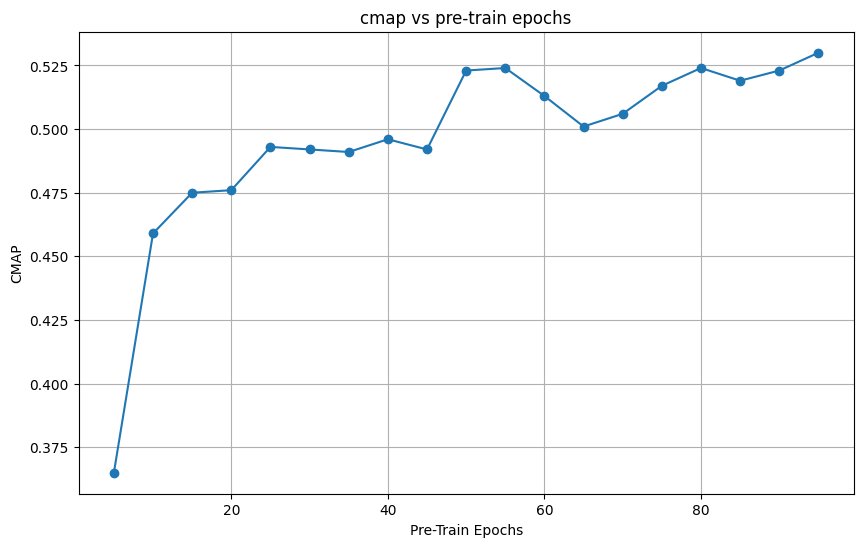

In [3]:
x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
y = [0.365, 0.459, 0.475, 0.476, 0.493, 0.492, 0.491, 0.496, 0.492, 0.523, 0.524, 0.513, 0.501, 0.506, 0.517, 0.524, 0.519, 0.523,0.530]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x[:len(y)], y, marker='o')
plt.xlabel('Pre-Train Epochs')
plt.ylabel('CMAP')
plt.title('cmap vs pre-train epochs')
plt.grid(True)
plt.show()

